In [17]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd

In [18]:
#read CSV data and convert to Pandas Dataframe for column exctraction, then check type.
#File M is the matrix of x and y from fit data in Matlab
g2_data = pd.read_csv("C:/Users/maris/Documents/QC_Modeling_Bayesian/crossCorr_M.csv", usecols=['photon_spacing', 'g2'])
# print(g2_data.head())
time_array = np.array(g2_data['photon_spacing'])
g2_array = np.array(g2_data['g2'])

Text(0, 0.5, 'Final Stage Pos. g(^2) Function')

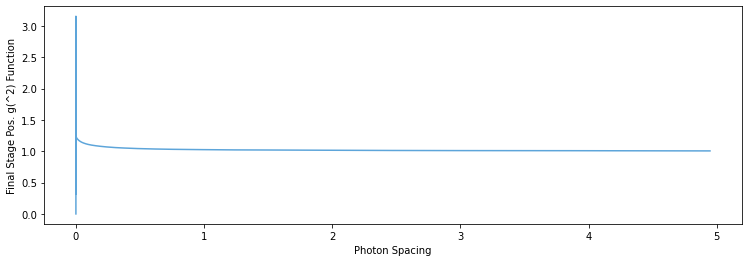

In [19]:
# Defining our Data into tensor array for TFP from Pd.Array type
# # Visualizing the Results as a check 
plt.figure(figsize=(12.5, 4))
plt.plot(time_array, g2_array, color="#5DA5DA")
#Arbitary x-label to match Andrews 20201031 MatLab axes
plt.xlabel("Photon Spacing")
plt.ylabel("Final Stage Pos. g(^2) Function")
#plt.ylim(0.8, 2.2)

Text(0, 0.5, 'Final Stage Pos. g(^2) Function')

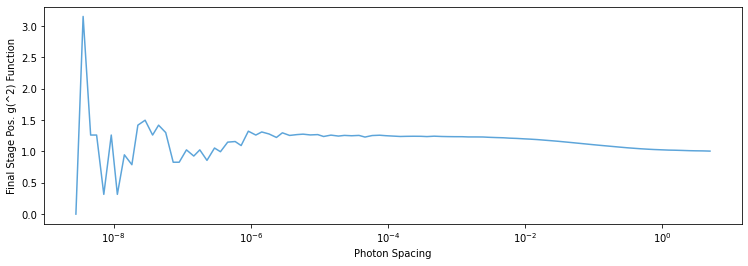

In [20]:
# Defining our Data into tensor array for TFP from Pd.Array type
# # Visualizing the Results as a check 
plt.figure(figsize=(12.5, 4))
plt.plot(time_array, g2_array, color="#5DA5DA")

plt.xscale('log')
plt.xlabel("Photon Spacing")
plt.ylabel("Final Stage Pos. g(^2) Function")

In [30]:
# set random seed for reproducibility
np.random.seed(12345)
x = time_array;

# Parameters for fit
A = 0.31
B = 5.8e-1
m = 0.1
Td = 3.6e-1
k = 2.7e-1
Ta = 4.00e-8

fit = lambda A, B, m, Td, k, Ta , x: 1+A*((1-B*x**(m))*1/(1+(x/Td)))-k*np.exp(-x/Ta)

model = fit(x=x, A= A, B= B, m= m, Td= Td, k= k, Ta =Ta)

# add noise to the data points
noise = np.random.normal(size=len(x)) * .02 
model_noise = model + noise 

# Determine absolute error between Model and g2_from_qutip
model_error = np.abs(model - g2_array)

(-0.1, 1.5)

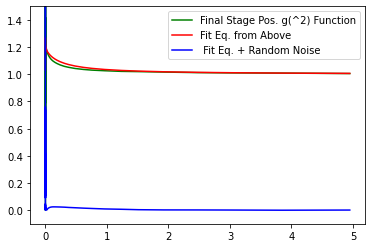

In [31]:
plt.plot(time_array, g2_array, color='g', label="Final Stage Pos. g(^2) Function")
plt.plot(time_array, model, color='r', label="Fit Eq. from Above")
plt.plot(time_array, model_error, color='b', label=" Model - G2_data")
plt.legend();
plt.ylim(-0.1,1.5)

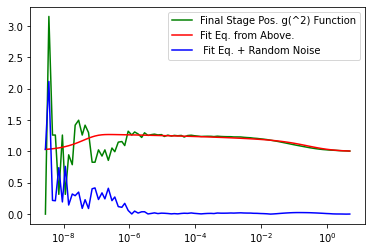

In [32]:
plt.plot(time_array, g2_array, color='g', label="Final Stage Pos. g(^2) Function")
plt.plot(time_array, model, color='r', label="Fit Eq. from Above.")
plt.plot(time_array, model_error, color='b', label=" Model - G2_data")
plt.xscale('log')
plt.legend();

In [33]:
with pm.Model() as model3:

    #To start, set all parameters to uniform, continuous distributions
    #test Values updated from an initial run
    A = pm.Uniform('A', 0.0, 0.81, testval = 0.31)
    B =  pm.Uniform('B', 0.0, 0.9, testval = 5.8e-1)
    m = pm.Uniform('m', 0.0, 1.0, testval = 0.1)
    Td = pm.Uniform('Td', 0.0, 0.5, testval = 3.6e-1)
    k = pm.Uniform('k', 0.0, 0.5, testval = 2.7e-1)
    Ta = pm.Uniform('Ta', 0.0, 0.1, testval = 4.00e-08)

    fit=pm.Deterministic('fit', (1+A*((1-B*x**(m))*1/(1+(x/Td)))-k*np.exp(-x/Ta)))
    
    #mu deterministic parameters
    y =pm.Normal('y', mu=fit, tau=1.0/model_error**2, observed=g2_array)

In [34]:
with model3:
    start=pm.find_MAP()
    trace=pm.sample(20000)

logp = 220.83, ||grad|| = 14.862: 100%|██████████████████████████████████████████████| 47/47 [00:00<00:00, 1625.78it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ta, k, Td, m, B, A]
Sampling 4 chains, 1,172 divergences: 100%|███████████████████████████████████| 82000/82000 [29:06<00:00, 46.96draws/s]
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9286431658451534, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6992764587130387, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smalle

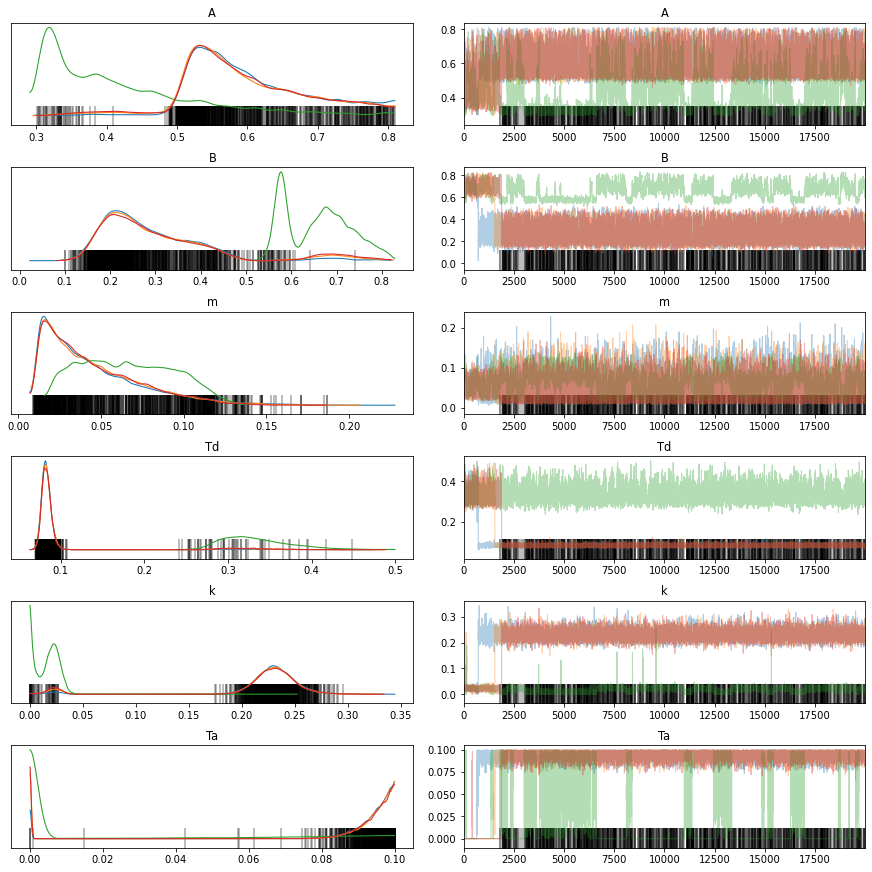

In [35]:
with model3:
    az.plot_trace(trace, var_names=["A","B","m","Td","k","Ta"])

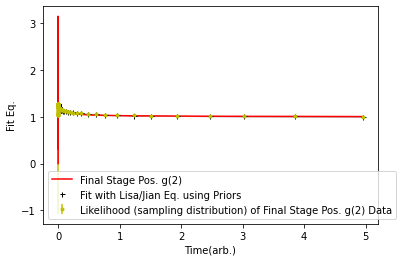

In [36]:
# extract and plot results Linear plot
y_min = np.percentile(trace.fit, 2.5, axis=0)
y_max = np.percentile(trace.fit, 97.5, axis=0)
y_fit = np.percentile(trace.fit, 50, axis=0)

plt.plot(time_array, g2_array,'r', label='Final Stage Pos. g(2)')
plt.errorbar(time_array, model, yerr=model_error, color='y', marker='.', ls='None', label='Likelihood (sampling distribution) of Final Stage Pos. g(2) Data')
plt.plot(time_array, y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit with Lisa/Jian Eq. using Priors')
plt.fill_between(time_array, y_min, y_max, color='0.5', alpha=0.5)
plt.legend();
plt.ylabel("Fit Eq.");
plt.xlabel("Time(arb.)");

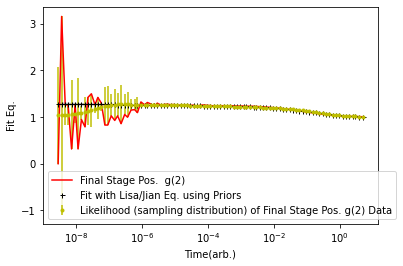

In [37]:
# extract and plot results Log Plot
y_min = np.percentile(trace.fit, 2.5, axis=0)
y_max = np.percentile(trace.fit, 97.5, axis=0)
y_fit = np.percentile(trace.fit, 50, axis=0)

plt.xscale('log')

plt.plot(time_array, g2_array,'r', label='Final Stage Pos.  g(2)')
plt.errorbar(time_array, model, yerr=model_error, color='y', marker='.', ls='None', label='Likelihood (sampling distribution) of Final Stage Pos. g(2) Data')
plt.plot(time_array, y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit with Lisa/Jian Eq. using Priors')
plt.fill_between(time_array, y_min, y_max, color='0.5', alpha=0.5)
plt.legend();
plt.ylabel("Fit Eq.");
plt.xlabel("Time(arb.)");